In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from skimage import io, color
import gc

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# for training with HSV channels

def rgb2hsv(input, epsilon=1e-10):
    assert(input.shape[0] == 3)

    r, g, b = input[0], input[1], input[2]
    max_rgb, argmax_rgb = input.max(0)
    min_rgb, argmin_rgb = input.min(0)

    max_min = max_rgb - min_rgb + epsilon 

    h1 = 60.0 * (g - r) / max_min + 60.0
    h2 = 60.0 * (b - g) / max_min + 180.0
    h3 = 60.0 * (r - b) / max_min + 300.0

    h = torch.stack((h2, h3, h1), dim=0).gather(dim=0, index=argmin_rgb.unsqueeze(0)).squeeze(0)
    s = max_min / (max_rgb + epsilon)
    v = max_rgb

    return torch.stack((h, s, v), dim=0)

def hsv2rgb(input):
    assert(input.shape[0] == 3)

    h, s, v = input[0], input[1], input[2]
    h_ = (h - torch.floor(h / 360) * 360) / 60
    c = s * v
    x = c * (1 - torch.abs(torch.fmod(h_, 2) - 1))

    zero = torch.zeros_like(c)
    y = torch.stack((
        torch.stack((c, x, zero), dim=0),
        torch.stack((x, c, zero), dim=0),
        torch.stack((zero, c, x), dim=0),
        torch.stack((zero, x, c), dim=0),
        torch.stack((x, zero, c), dim=0),
        torch.stack((c, zero, x), dim=0),
    ), dim=0)
    index = torch.repeat_interleave(torch.floor(h_).unsqueeze(0), 3, dim=0).unsqueeze(0).to(torch.long)
    rgb = (y.gather(dim=0, index=index) + (v - c)).squeeze(0)
    return rgb

# for training with LAB channels

def preprocess(img):
    # img - image tensor
    img_original = img.numpy().transpose((1, 2, 0))
    img_lab = color.rgb2lab(img_original)
    img_lab = (img_lab + 128) / 255
    img_ab = img_lab[:, :, 1:3]
    img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
    img_l = img_lab[:, :, 0]
    img_l = torch.from_numpy(img_l).float().unsqueeze(0)
    img_gray = color.rgb2gray(img_original)
    img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()
    return img_gray, img_ab, img_l

def combinelab2rgb(l, a, b):
    # l, a, b - image tensors representing LAB channels
    img_lab = torch.stack([l, a, b])
    img_lab = img_lab * 255 - 128
    img_rgb = color.lab2rgb(img_lab.cpu().detach().numpy().transpose((1, 2, 0)))
    img_rgb = torch.from_numpy(img_rgb.transpose((2, 0, 1))).float()
    return img_rgb

/homes/iws/lpremc/miniconda3/envs/cse455/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import datetime
import re

In [ ]:
re.sub(str(datetime.datetime.now()))

In [10]:
time = str(datetime.datetime.now()).replace('.', ':').replace(' ', '_')

In [71]:
# global feature extractor based on Resnet152
class ExtractorResnet152(nn.Module):
    def __init__(self):
        super(ExtractorResnet152, self).__init__()
        model = torchvision.models.resnet152()
        model.conv1.weight = nn.Parameter(model.conv1.weight.sum(dim=1).unsqueeze(1))
        self.layers = nn.Sequential(
            *list(model.children())[0:6]
        )

    def forward(self, x):
        x = self.layers(x)
        return x

# auto encoder decoder based on Resnet18
class ColorNetResnet18(nn.Module):

    def __init__(self, mid_input_size=0):
        super(ColorNetResnet18, self).__init__()
        self.mid_input_size = mid_input_size
        resnet = torchvision.models.resnet18()
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
        self.encoder = nn.Sequential(*list(resnet.children())[0:6])
        self.decoder = nn.Sequential(
            nn.Conv2d(mid_input_size + 128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Softmax(),
            nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=4)
        )

    def forward(self, x, in_=None):
        x = self.encoder(x)
        if self.mid_input_size > 0:
            x = torch.cat([x, in_], dim=1)
        x = self.decoder(x)
        return x

class Decoder(nn.Module):

    def __init__(self, mid_input_size):
        super(Decoder, self).__init__()
        self.mid_input_size = mid_input_size
        self.decoder = nn.Sequential(
            nn.Conv2d(mid_input_size, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Softmax(),
            nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=4)
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

In [72]:
models = {
    "decoder": Decoder,
    "resnet18": ColorNetResnet18
}
extractors = {
    "resnet152": ExtractorResnet152
}
model_name = "decoder"
extractor = ExtractorResnet152()
model = models[model_name](mid_input_size=extractor(torch.zeros((1, 1, 256, 256))).shape[1])
# model.load_state_dict(torch.load('models/auto_color.pth'))
extractor.to(device)
model.to(device)

Decoder(
  (decoder): Sequential(
    (0): Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): Softmax(dim=None)
    (17): Conv2d(32, 2, kernel_size=(3, 3), stride=(1, 1), padd

In [38]:
def get_datasets(dataset_path):
    dataset = torchvision.datasets.ImageFolder(dataset_path, transform=T.Compose([
        T.Resize((256, 256)),
        T.ToTensor()
    ]))

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    return torch.utils.data.random_split(dataset, [train_size, test_size])
lhq256_train, lhq256_test = get_datasets("LHQ256")

In [73]:
time = str(datetime.datetime.now()).replace('.', ':').replace(' ', '_')
checkpoint_path = f'models/{model_name}_{time}.pth'

def train(model, extractor, train_dataset, plot_name, num_batches=10, batch_size=16, epochs=100, lr=0.1, decay=1e-10):
  model.to(device)
  extractor.to(device)
  losses = []
  criterion = nn.MSELoss().to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
  min_loss = 10000
  with tqdm(range(epochs)) as eps:
    for e in eps:
      total_loss = 0
      # train for num_batches batches per epoch
      for idx in range(num_batches):
        try:
          # sample an image batch
          batch_idx = random.choices(np.arange(len(train_dataset)), k=batch_size)
          train_images = [preprocess(train_dataset[n][0]) for n in batch_idx]
          gray_inputs = torch.stack([im[0] for im in train_images]).to(device)
          ab_inputs = torch.stack([im[1] for im in train_images]).to(device)
        except:
          continue
        
        # backpropagate and step
        optimizer.zero_grad()
        global_features = extractor(gray_inputs).to(device)
        ab_outputs = model(global_features).to(device)
        loss = criterion(ab_outputs, ab_inputs)
        loss.backward()
        optimizer.step()

        # clear memory
        del gray_inputs
        del ab_inputs
        del global_features
        del ab_outputs
        gc.collect()
        torch.cuda.empty_cache()
        total_loss += loss.item().real

        eps.set_postfix(progress=str(idx/num_batches * 100) +"%")

      # mean loss per epoch
      mean_loss = total_loss / num_batches
      eps.set_postfix(loss=mean_loss)

      # save model if perform better
      if (mean_loss < min_loss):
        min_loss = mean_loss
        torch.save(model.state_dict(), checkpoint_path)

      # plot losses
      if (e % 20 == 0 and e != 0):
        losses.append(mean_loss)
        plt.figure()
        plt.plot(losses)
        plt.yscale('log')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.savefig(plot_name)
        plt.close('all')

In [42]:
train(model, extractor, lhq256_train, num_batches=1, batch_size=16, epochs=1000, lr=0.01, plot_name=f"plots/losses_{time}.png")

  0%|          | 0/2000 [00:00<?, ?it/s]/homes/iws/lpremc/miniconda3/envs/cse455/lib/python3.9/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 2000/2000 [25:43<00:00,  1.30it/s, loss=0.00226] 


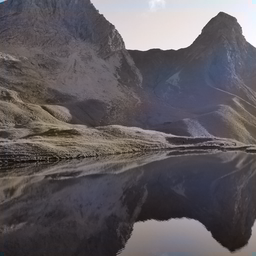

In [69]:
# try predict colors
dataset = lhq256_test
batch_idx = random.choices(range(len(dataset)), k=1)
test_images = [preprocess(dataset[n][0]) for n in batch_idx]
gray_inputs = torch.stack([im[0] for im in test_images]).to(device)
ab_inputs = torch.stack([im[1] for im in test_images]).to(device)
l_inputs = torch.stack([im[2] for im in test_images]).to(device)
global_features = extractor(gray_inputs)
ab_outputs = model(global_features)
rgb_inputs = torch.stack([dataset[n][0] for n in batch_idx])
rgb_outputs = torch.stack([combinelab2rgb(l_inputs[i][0], ab_outputs[i][0], ab_outputs[i][1]) for i in range(len(ab_outputs))])
T.ToPILImage()(rgb_outputs[0])

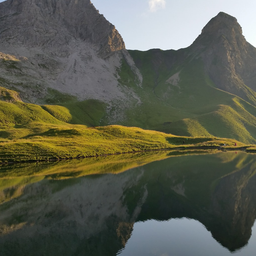

In [70]:
T.ToPILImage()(rgb_inputs[0])